# Tri-Model Asymmetric Distillation (Enhanced with Logits Distillation) — Sports-in-the-Wild

## New Features Added:
- **Logits Distillation**: Direct knowledge transfer from teacher/assistant final predictions to student
- **Separate Temperature Control**: Independent temperature settings for feature vs logits distillation
- **Asymmetric Logits Weighting**: Different weights for teacher vs assistant logits contributions
- **Enhanced Loss Tracking**: Detailed metrics for all distillation components

## Knowledge Transfer Pathways:
1. **Feature Distillation**: Hidden representations → Student learns internal feature maps
2. **Attention Distillation**: Attention patterns → Student learns where to focus
3. **Logits Distillation** (NEW): Final predictions → Student learns decision-making
4. **Classification Loss**: Ground truth → Student learns target task

This enhanced setup provides more comprehensive knowledge transfer and better utilization of both teacher models.

# Tri-Model Asymmetric Distillation (Multiclass) — Sports-in-the-Wild

This notebook trains a compact student VideoMAE model on Sports-in-the-Wild using tri-model asymmetric distillation:
- Teacher: `mitegvg/videomae-base-finetuned-kinetics-finetuned-sports-videos-in-the-wild`
- Assistant: `mitegvg/videomae-base-finetuned-ucf101-finetuned-sports-videos-in-the-wild`
- Student (pretrained): `mitegvg/videomae-tiny-finetuned-kinetics-finetuned-sports-videos-in-the-wild`

Major differences vs. XD-Violence setup:
- Multiclass labels derived from `processed_dataset/*.csv` (no binary mapping)
- Slightly different distillation weights that tend to work better for multiclass


In [1]:
# Environment
import os
import json
import torch
from transformers import TrainingArguments

# Local tri-model modules
from tri_model_distillation.config import TriModelConfig
from tri_model_distillation.models import TriModelDistillationFramework
from tri_model_distillation.trainer import TriModelDistillationTrainer, compute_video_classification_metrics
from tri_model_distillation.utils import (
    setup_logging, load_label_mappings, create_data_loaders,
    print_model_info, save_training_config
)

print(torch.__version__)
print(torch.cuda.is_available())


C:\Users\order\.conda\envs\videomae\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


2.1.0+cu118
True


In [2]:

# Import required for datetime
from datetime import datetime
# Paths and dataset settings
DATASET_ROOT = "processed_dataset"
OUTPUT_DIR = f"./tri_model_distilled_sports_multiclass_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Detect labels for multiclass
label2id, id2label = load_label_mappings(dataset_root=DATASET_ROOT, train_csv="train.csv", classification_type="multiclass")
num_labels = len(label2id)
print(f"Classes ({num_labels}):", list(label2id.keys())[:100], ("..." if num_labels > 100 else ""))


Classes (30): ['archery', 'baseball', 'basketball', 'bmx', 'bowling', 'boxing', 'cheerleading', 'discusthrow', 'diving', 'football', 'golf', 'gymnastics', 'hammerthrow', 'highjump', 'hockey', 'hurdling', 'javelin', 'longjump', 'polevault', 'rowing', 'running', 'shotput', 'skating', 'skiing', 'soccer', 'swimming', 'tennis', 'volleyball', 'weight', 'wrestling'] 


In [3]:
# Tri-model configuration with logits distillation
tri_config = TriModelConfig(
    classification_type="multiclass", 
    num_labels=num_labels,
    teacher_model_name="mitegvg/videomae-base-finetuned-kinetics-finetuned-sports-videos-in-the-wild",
    assistant_model_name="mitegvg/videomae-base-finetuned-ucf101-finetuned-sports-videos-in-the-wild",
    student_model_name="mitegvg/videomae-tiny-finetuned-kinetics-finetuned-sports-videos-in-the-wild",
    
    # Loss weights - including logits distillation
    classification_loss_weight=1.0, 
    feature_distillation_weight=0.05,  
    attention_distillation_weight=0.05,
    logits_distillation_weight=0.8,  # NEW: Strong logits distillation for knowledge transfer
    
    # Temperature settings
    temperature=4.0,  # Higher temperature for softer knowledge transfer in multiclass
    logits_temperature=3.0,  # NEW: Separate temperature for logits (often lower than feature temp)
    
    # Asymmetric weights
    teacher_feature_weight=1.0,  # Full weight for primary teacher
    assistant_feature_weight=0.6,  # Moderate weight for assistant (from UCF101)
    teacher_logits_weight=1.0,  # NEW: Full weight for teacher logits
    assistant_logits_weight=0.6,  # NEW: Moderate weight for assistant logits
    
    # Training stability
    use_pretrained_student=True,  # Confirmed this is already True by default
    num_frames=16,  # Standard for VideoMAE
)

print("🔧 Tri-Model Configuration with Logits Distillation:")
print(f"   🎯 Classification loss weight: {tri_config.classification_loss_weight}")
print(f"   🧠 Feature distillation weight: {tri_config.feature_distillation_weight}")
print(f"   👁️ Attention distillation weight: {tri_config.attention_distillation_weight}")
print(f"   📊 Logits distillation weight: {tri_config.logits_distillation_weight}")
print(f"   🌡️ Feature temperature: {tri_config.temperature}")
print(f"   📈 Logits temperature: {tri_config.logits_temperature}")
print(f"   👨‍🏫 Teacher logits weight: {tri_config.teacher_logits_weight}")
print(f"   🤝 Assistant logits weight: {tri_config.assistant_logits_weight}")

# Calculate optimal batch size and steps based on dataset size
total_train_samples = 3364  # Number of lines in train.csv (from wc -l command)
batch_size = 4 if torch.cuda.is_available() else 2
gradient_accumulation_steps = 8 if torch.cuda.is_available() else 4
effective_batch_size = batch_size * gradient_accumulation_steps

# Calculate training steps
num_epochs = 20
steps_per_epoch = total_train_samples // effective_batch_size
total_training_steps = steps_per_epoch * num_epochs
warmup_steps = min(500, int(0.1 * total_training_steps))

# Evaluation frequency
eval_steps = max(50, steps_per_epoch // 10)
save_steps = max(100, steps_per_epoch // 5)

per_device_train_batch_size=batch_size

🔧 Tri-Model Configuration with Logits Distillation:
   🎯 Classification loss weight: 1.0
   🧠 Feature distillation weight: 0.05
   👁️ Attention distillation weight: 0.05
   📊 Logits distillation weight: 0.8
   🌡️ Feature temperature: 4.0
   📈 Logits temperature: 3.0
   👨‍🏫 Teacher logits weight: 1.0
   🤝 Assistant logits weight: 0.6


In [4]:
# Initialize framework and data loaders
setup_logging()

framework = TriModelDistillationFramework(
    config=tri_config,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

model_info = framework.get_model_info()
print("Teacher:", model_info['teacher'])
print("Assistant:", model_info['assistant'])
print("Student:", model_info['student'])

train_loader, val_loader, test_loader = create_data_loaders(
    dataset_root=DATASET_ROOT,
    image_processor=framework.image_processor,
    label2id=label2id,
    batch_size=per_device_train_batch_size,  # Add keyword argument name
    num_frames=tri_config.num_frames,
    num_workers=2,
)

# Add this cell before the training cell in your notebook

def check_model_compatibility(framework):
    """
    Check if teacher, assistant, and student models have compatible output dimensions
    for logits distillation.
    """
    print("🔍 Checking model compatibility for logits distillation...")
    
    # Get number of labels from each model
    teacher_labels = framework.teacher_model.config.num_labels
    assistant_labels = framework.assistant_model.config.num_labels  
    student_labels = framework.student_model.config.num_labels
    
    print(f"   👨‍🏫 Teacher model: {teacher_labels} classes")
    print(f"   🤝 Assistant model: {assistant_labels} classes") 
    print(f"   🎓 Student model: {student_labels} classes")
    
    # Check compatibility
    models_match = (teacher_labels == student_labels and 
                   assistant_labels == student_labels)
    
    if models_match:
        print("✅ All models have matching output dimensions - logits distillation will work correctly")
        return True
    else:
        print("⚠️ WARNING: Models have different output dimensions!")
        print("   📊 Logits distillation may fail due to dimension mismatch")
        print("   💡 Consider:")
        print("      - Using models with same number of classes")
        print("      - Reducing logits_distillation_weight to 0.0")
        print("      - Adding dimension alignment (advanced)")
        
        # Ask user what to do
        response = input("\n❓ Continue training anyway? (y/n): ").lower().strip()
        return response in ['y', 'yes']

# Check compatibility before training
if not check_model_compatibility(framework):
    print("🛑 STOP: Training stopped due to model incompatibility")
    

2025-08-19 22:12:23,094 - tri_model_distillation.models - INFO - Initializing Tri-Model Distillation Framework for multiclass classification...
2025-08-19 22:12:23,096 - tri_model_distillation.models - INFO - Loading teacher model...
2025-08-19 22:12:25,004 - tri_model_distillation.models - INFO - Loading assistant model...
2025-08-19 22:12:25,005 - tri_model_distillation.models - INFO - Loading assistant model from HuggingFace: mitegvg/videomae-base-finetuned-ucf101-finetuned-sports-videos-in-the-wild
2025-08-19 22:12:26,878 - tri_model_distillation.models - INFO - Loading student model with label alignment...
2025-08-19 22:12:27,030 - tri_model_distillation.models - INFO - All label mappings match perfectly!
2025-08-19 22:12:27,031 - tri_model_distillation.models - INFO - Label mappings actually match - loading pretrained model directly
2025-08-19 22:12:28,535 - tri_model_distillation.utils - INFO - Loaded 3364 video paths from train.csv
2025-08-19 22:12:28,553 - tri_model_distillati

Teacher: {'name': 'mitegvg/videomae-base-finetuned-kinetics-finetuned-sports-videos-in-the-wild', 'num_parameters': 86250270, 'trainable_parameters': 0}
Assistant: {'name': 'mitegvg/videomae-base-finetuned-ucf101-finetuned-sports-videos-in-the-wild', 'num_parameters': 86250270, 'trainable_parameters': 0}
Student: {'name': 'mitegvg/videomae-tiny-finetuned-kinetics-finetuned-sports-videos-in-the-wild', 'num_parameters': 7698846, 'trainable_parameters': 7698846}


2025-08-19 22:12:28,572 - tri_model_distillation.utils - INFO - Loaded 422 video paths from test.csv
2025-08-19 22:12:28,573 - tri_model_distillation.utils - INFO - Created data loaders:
2025-08-19 22:12:28,574 - tri_model_distillation.utils - INFO -   Train: 3364 samples, 841 batches
2025-08-19 22:12:28,575 - tri_model_distillation.utils - INFO -   Val: 420 samples, 105 batches
2025-08-19 22:12:28,575 - tri_model_distillation.utils - INFO -   Test: 422 samples, 106 batches


🔍 Checking model compatibility for logits distillation...
   👨‍🏫 Teacher model: 30 classes
   🤝 Assistant model: 30 classes
   🎓 Student model: 30 classes
✅ All models have matching output dimensions - logits distillation will work correctly


In [ ]:
# Trainer and training loop - FIXED for proper progress display AND live per-epoch reporting

# Use the config's method to create training arguments
training_args = tri_config.to_training_args(
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size,
    num_train_epochs=num_epochs,
    warmup_steps=warmup_steps,
    
    # FIXED: Per-epoch evaluation and logging for live table
    evaluation_strategy="epoch",  # Changed from "steps" to "epoch"
    logging_strategy="epoch",     # Changed from "steps" to "epoch"
    logging_steps=10,  # Still useful for within-epoch progress
    logging_first_step=True,  # Log the first step
    
    # FIXED: Save configuration (keeping steps for more frequent saves)
    save_strategy="steps",
    save_steps=save_steps,
    save_total_limit=3,  # Keep only 3 checkpoints
    
    # FIXED: Progress display settings for live reporting
    disable_tqdm=False,  # Enable progress bars
    report_to=["tensorboard"],  # Enable tensorboard for live tracking
    logging_dir=f"{OUTPUT_DIR}/logs",
    
    # FIXED: Metrics configuration
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    load_best_model_at_end=True,
    
    # FIXED: Memory and performance settings
    remove_unused_columns=False,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,  # Set to 0 for debugging
    
    # FIXED: Output settings
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    
    # FIXED: Gradient settings
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=1.0,
    
    # FIXED: Additional logging
    log_level="info",
    logging_nan_inf_filter=True,
)

# Print configuration for verification
print("🔧 Training Arguments Configuration:")
print(f"   📊 Logging strategy: {training_args.logging_strategy}")
print(f"   📈 Evaluation strategy: {training_args.evaluation_strategy}")
print(f"   💾 Save steps: {training_args.save_steps}")
print(f"   🔄 Disable tqdm: {training_args.disable_tqdm}")
print(f"   📝 Report to: {training_args.report_to}")

# Create trainer with enhanced logging
trainer = TriModelDistillationTrainer(
    framework=framework,
    distillation_config=tri_config,
    args=training_args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    compute_metrics=lambda eval_pred, **kwargs: compute_video_classification_metrics(
        eval_pred, 
        classification_type=kwargs.get('classification_type', 'multiclass')
    ),
)

# BONUS: Force notebook training tracker for live HTML table
from transformers.integrations import NotebookTrainingTrackerCallback
trainer.add_callback(NotebookTrainingTrackerCallback())
print("✅ Added NotebookTrainingTrackerCallback for live per-epoch table")

# FIXED: Enable detailed progress tracking
print("🚀 Starting training with enhanced progress tracking...")
print(f"   📦 Total training samples: {len(train_loader.dataset)}")
print(f"   🔢 Steps per epoch: {steps_per_epoch}")
print(f"   📊 Total training steps: {total_training_steps}")
print(f"   📈 Evaluation every epoch (instead of every {eval_steps} steps)")
print(f"   📋 Live per-epoch table will appear below during training")

train_result = trainer.train()
print("✅ Training completed!")
print(train_result)

# Save model and config
trainer.save_model(OUTPUT_DIR)

# Evaluate
val_metrics = trainer.evaluate(eval_dataset=val_loader.dataset)
print("Validation:", val_metrics)

test_metrics = trainer.evaluate(eval_dataset=test_loader.dataset, metric_key_prefix="test")
print("Test:", test_metrics)

🔧 Training Arguments Configuration:
   📊 Logging steps: 10
   📈 Eval steps: 50
   💾 Save steps: 100
   🔄 Disable tqdm: False
   📝 Report to: ['tensorboard']


Using auto half precision backend
***** Running training *****
  Num examples = 3,364
  Num Epochs = 20
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 2,100
  Number of trainable parameters = 7,698,846


🚀 Starting training with enhanced progress tracking...
   📦 Total training samples: 3364
   🔢 Steps per epoch: 105
   📊 Total training steps: 2100
   📈 Evaluation every 50 steps


Step,Training Loss,Validation Loss


Configuration saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-100\config.json
Model weights saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-100\model.safetensors
Image processor saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-100\preprocessor_config.json
2025-08-19 22:36:19,405 - tri_model_distillation.models - INFO - Student model saved to ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-100
2025-08-19 22:36:19,406 - tri_model_distillation.trainer - INFO - Tri-model distillation framework saved to ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-100
Configuration saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-200\config.json
Model weights saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-200\model.safetensors
Image processor saved in ./tri_model_distilled_sports_multiclass_20250819_221210\checkpoint-200\preproces

✅ Training completed!
TrainOutput(global_step=2100, training_loss=74.92511500767299, metrics={'train_runtime': 31818.1307, 'train_samples_per_second': 2.115, 'train_steps_per_second': 0.066, 'total_flos': 7.417056438565208e+18, 'train_loss': 74.92511500767299, 'model/student_params': 7698846, 'model/teacher_params': 86250270, 'model/assistant_params': 86250270, 'epoch': 19.81807372175981})
Validation: {'eval_loss': 81.8785909016927, 'eval_classification_loss': 1.9278553687390827, 'eval_feature_distillation_loss': 726.9948137555804, 'eval_attention_distillation_loss': 0.0006310126101154657, 'eval_logits_distillation_loss': 9.03512229465303, 'eval_accuracy': 0.46190476190476193, 'eval_precision_macro': 0.4425534664044221, 'eval_precision_micro': 0.46190476190476193, 'eval_precision_weighted': 0.44952711140161866, 'eval_recall_macro': 0.4478836659842852, 'eval_recall_micro': 0.46190476190476193, 'eval_recall_weighted': 0.46190476190476193, 'eval_f1_macro': 0.4308998345290826, 'eval_f1_mic

In [8]:
# Save the final model to the correct directory
final_output_dir = OUTPUT_DIR
trainer.save_model(final_output_dir)
print(f"Model saved to {final_output_dir}")

Configuration saved in ./tri_model_distilled_sports_multiclass_20250819_174836\config.json
Model weights saved in ./tri_model_distilled_sports_multiclass_20250819_174836\model.safetensors
Image processor saved in ./tri_model_distilled_sports_multiclass_20250819_174836\preprocessor_config.json
2025-08-19 18:39:01,536 - tri_model_distillation.models - INFO - Student model saved to ./tri_model_distilled_sports_multiclass_20250819_174836
2025-08-19 18:39:01,537 - tri_model_distillation.trainer - INFO - Tri-model distillation framework saved to ./tri_model_distilled_sports_multiclass_20250819_174836


Model saved to ./tri_model_distilled_sports_multiclass_20250819_174836


In [10]:
# Model Evaluation and Analysis
# Core ML Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import sys
import logging
import warnings
import importlib
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the saved model for detailed evaluation
student_model_path = OUTPUT_DIR
print(f"Loading model from {student_model_path} for evaluation...")

from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the model
student_model = VideoMAEForVideoClassification.from_pretrained(student_model_path)
student_model.to(device)
student_model.eval()

# Evaluate on test dataset with detailed metrics
print(f"Test dataset size: {len(test_loader.dataset)} samples")

# Define a function to compute detailed metrics
def compute_detailed_metrics(model, dataloader, id2label):
    """Compute detailed metrics for model evaluation"""
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Per-class accuracy
    class_accuracy = {}
    for i in range(len(id2label)):
        class_indices = np.where(np.array(all_labels) == i)[0]
        if len(class_indices) > 0:
            class_correct = sum(np.array(all_preds)[class_indices] == i)
            class_accuracy[id2label[i]] = class_correct / len(class_indices)
    
    # Overall accuracy
    accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    return {
        "confusion_matrix": cm,
        "class_accuracy": class_accuracy,
        "overall_accuracy": accuracy,
        "predictions": all_preds,
        "labels": all_labels
    }

# Run detailed evaluation
detailed_metrics = compute_detailed_metrics(student_model, test_loader, id2label)

# Display results
print(f"Overall accuracy: {detailed_metrics['overall_accuracy']:.4f}")
print("\nTop 5 best performing classes:")
sorted_classes = sorted(detailed_metrics['class_accuracy'].items(), key=lambda x: x[1], reverse=True)
for cls, acc in sorted_classes[:5]:
    print(f"  - {cls}: {acc:.4f}")

print("\nBottom 5 classes:")
for cls, acc in sorted_classes[-5:]:
    print(f"  - {cls}: {acc:.4f}")

# Plot confusion matrix (if not too many classes)
if len(id2label) <= 20:  # Only plot if reasonable size
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=detailed_metrics['confusion_matrix'],
        display_labels=[id2label[i] for i in range(len(id2label))]
    )
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("Too many classes for confusion matrix visualization")

# Save results
import json
with open(f"{OUTPUT_DIR}/detailed_evaluation.json", "w") as f:
    # Convert numpy arrays to lists for JSON serialization
    results = {
        "overall_accuracy": float(detailed_metrics['overall_accuracy']),
        "class_accuracy": {k: float(v) for k, v in detailed_metrics['class_accuracy'].items()}
    }
    json.dump(results, f, indent=2)
print(f"\nDetailed evaluation results saved to {OUTPUT_DIR}/detailed_evaluation.json")


loading configuration file ./tri_model_distilled_sports_multiclass_20250819_174836\config.json
Model config VideoMAEConfig {
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "id2label": {
    "0": "archery",
    "1": "baseball",
    "2": "basketball",
    "3": "bmx",
    "4": "bowling",
    "5": "boxing",
    "6": "cheerleading",
    "7": "discusthrow",
    "8": "diving",
    "9": "football",
    "10": "golf",
    "11": "gymnastics",
    "12": "hammerthrow",
    "13": "highjump",
    "14": "hockey",
    "15": "hurdling",
    "16": "javelin",
    "17": "longjump",
    "18": "polevault",
    "19": "rowing",
    "20": "running",
    "21": "shotput",
    "22": "skating",
    "23": "skiing",
    "24": "soccer",
    "25": "swimm

Loading model from ./tri_model_distilled_sports_multiclass_20250819_174836 for evaluation...


All model checkpoint weights were used when initializing VideoMAEForVideoClassification.

All the weights of VideoMAEForVideoClassification were initialized from the model checkpoint at ./tri_model_distilled_sports_multiclass_20250819_174836.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VideoMAEForVideoClassification for predictions without further training.


Test dataset size: 422 samples


Evaluating:   0%|          | 0/106 [00:00<?, ?it/s]

Overall accuracy: 0.4573

Top 5 best performing classes:
  - swimming: 0.9655
  - hockey: 0.7857
  - gymnastics: 0.7059
  - bowling: 0.7000
  - skating: 0.6923

Bottom 5 classes:
  - hurdling: 0.2143
  - shotput: 0.1176
  - highjump: 0.0625
  - boxing: 0.0000
  - running: 0.0000
Too many classes for confusion matrix visualization

Detailed evaluation results saved to ./tri_model_distilled_sports_multiclass_20250819_174836/detailed_evaluation.json


In [11]:
# Model Inference Demo

print("Loading saved model for inference...")
inference_model = VideoMAEForVideoClassification.from_pretrained(OUTPUT_DIR)
inference_processor = VideoMAEImageProcessor.from_pretrained(OUTPUT_DIR)
inference_model.to(device)
inference_model.eval()

# Function for inference
def run_inference(video_path, model, processor, id2label):
    """Run inference on a single video"""
    try:
        import cv2
        from tqdm import tqdm
        
        # Read video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            return None
        
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Sample frames uniformly
        num_frames = 16
        frame_indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)
        frames = []
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        
        cap.release()
        
        if len(frames) != num_frames:
            print(f"Error: Could not extract enough frames from {video_path}")
            return None
        
        # Process frames
        inputs = processor(frames, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get predictions
        logits = outputs.logits[0]
        probs = torch.softmax(logits, dim=0)
        
        # Get top 5 predictions
        top5_probs, top5_indices = torch.topk(probs, 5)
        
        results = []
        for i, (prob, idx) in enumerate(zip(top5_probs.cpu().numpy(), top5_indices.cpu().numpy())):
            results.append({
                "rank": i+1,
                "class": id2label[idx],
                "probability": float(prob)
            })
        
        return {
            "top_predictions": results,
            "top_class": id2label[top5_indices[0].item()],
            "confidence": float(top5_probs[0])
        }
        
    except Exception as e:
        print(f"Inference error: {e}")
        return None

# Demo on a test sample
print("\nDemo inference on test samples:")

# Try to find a few test videos
import os
import random

test_videos = []
test_dir = os.path.join(DATASET_ROOT, "videos")
if os.path.exists(test_dir):
    all_videos = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.mp4')]
    test_videos = random.sample(all_videos, min(3, len(all_videos)))

if not test_videos:
    # Fallback to any video in the dataset
    for root, dirs, files in os.walk(DATASET_ROOT):
        for file in files:
            if file.endswith('.mp4'):
                test_videos.append(os.path.join(root, file))
                if len(test_videos) >= 3:
                    break
        if len(test_videos) >= 3:
            break

# Run inference on test videos
if test_videos:
    for i, video_path in enumerate(test_videos):
        print(f"\nTest video {i+1}: {os.path.basename(video_path)}")
        results = run_inference(video_path, inference_model, inference_processor, id2label)
        if results:
            print(f"Top prediction: {results['top_class']} (confidence: {results['confidence']:.4f})")
            print("Top 5 predictions:")
            for pred in results['top_predictions']:
                print(f"  {pred['rank']}. {pred['class']}: {pred['probability']:.4f}")
else:
    print("No test videos found. Please check your dataset paths.")

print("\nModel inference example completed!")


loading configuration file ./tri_model_distilled_sports_multiclass_20250819_174836\config.json
Model config VideoMAEConfig {
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "id2label": {
    "0": "archery",
    "1": "baseball",
    "2": "basketball",
    "3": "bmx",
    "4": "bowling",
    "5": "boxing",
    "6": "cheerleading",
    "7": "discusthrow",
    "8": "diving",
    "9": "football",
    "10": "golf",
    "11": "gymnastics",
    "12": "hammerthrow",
    "13": "highjump",
    "14": "hockey",
    "15": "hurdling",
    "16": "javelin",
    "17": "longjump",
    "18": "polevault",
    "19": "rowing",
    "20": "running",
    "21": "shotput",
    "22": "skating",
    "23": "skiing",
    "24": "soccer",
    "25": "swimm

Loading saved model for inference...


All model checkpoint weights were used when initializing VideoMAEForVideoClassification.

All the weights of VideoMAEForVideoClassification were initialized from the model checkpoint at ./tri_model_distilled_sports_multiclass_20250819_174836.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VideoMAEForVideoClassification for predictions without further training.
loading configuration file ./tri_model_distilled_sports_multiclass_20250819_174836\preprocessor_config.json
Image processor VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}




Demo inference on test samples:

Test video 1: video_000912.mp4
Top prediction: gymnastics (confidence: 0.5274)
Top 5 predictions:
  1. gymnastics: 0.5274
  2. boxing: 0.1868
  3. cheerleading: 0.1755
  4. volleyball: 0.0265
  5. wrestling: 0.0241

Test video 2: video_000204.mp4
Top prediction: tennis (confidence: 0.1549)
Top 5 predictions:
  1. tennis: 0.1549
  2. hammerthrow: 0.1470
  3. diving: 0.1365
  4. discusthrow: 0.1016
  5. golf: 0.0921

Test video 3: video_002253.mp4
Top prediction: javelin (confidence: 0.4351)
Top 5 predictions:
  1. javelin: 0.4351
  2. hurdling: 0.1197
  3. discusthrow: 0.1147
  4. running: 0.0886
  5. longjump: 0.0637

Model inference example completed!


In [12]:
# Feature Alignment Analysis

print("\nAnalyzing feature alignment between models...")

# Import visualization libraries if needed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import torch.nn.functional as F

def visualize_feature_alignment(framework, sample_batch, id2label):
    """Visualize feature alignment between teacher, assistant, and student models"""
    # Ensure models are in eval mode
    framework.teacher_model.eval()
    framework.assistant_model.eval()
    framework.student_model.eval()
    
    # Move batch to device
    pixel_values = sample_batch["pixel_values"].to(device)
    labels = sample_batch["labels"].to(device)
    
    # Get features from all models
    with torch.no_grad():
        # Teacher features
        teacher_outputs = framework.teacher_model(
            pixel_values=pixel_values,
            output_hidden_states=True
        )
        teacher_features = teacher_outputs.hidden_states[-1][:, 0].cpu().numpy()  # CLS token
        
        # Assistant features
        assistant_outputs = framework.assistant_model(
            pixel_values=pixel_values,
            output_hidden_states=True
        )
        assistant_features = assistant_outputs.hidden_states[-1][:, 0].cpu().numpy()
        
        # Student features
        student_outputs = framework.student_model(
            pixel_values=pixel_values,
            output_hidden_states=True
        )
        student_features = student_outputs.hidden_states[-1][:, 0].cpu().numpy()
    
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    
    # Create a combined dataset for PCA
    combined_features = np.vstack([teacher_features, assistant_features, student_features])
    combined_pca = pca.fit_transform(combined_features)
    
    # Split back into separate models
    batch_size = teacher_features.shape[0]
    teacher_pca = combined_pca[:batch_size]
    assistant_pca = combined_pca[batch_size:2*batch_size]
    student_pca = combined_pca[2*batch_size:]
    
    # Plot
    plt.figure(figsize=(12, 10))
    
    # Convert labels to class names
    label_names = [id2label[l.item()] for l in labels.cpu()]
    
    # Create scatter plots
    plt.scatter(teacher_pca[:, 0], teacher_pca[:, 1], marker='o', s=100, label='Teacher', alpha=0.7)
    plt.scatter(assistant_pca[:, 0], assistant_pca[:, 1], marker='s', s=100, label='Assistant', alpha=0.7)
    plt.scatter(student_pca[:, 0], student_pca[:, 1], marker='x', s=100, label='Student', alpha=0.7)
    
    # Add arrows from teacher to student
    for i in range(batch_size):
        plt.arrow(teacher_pca[i, 0], teacher_pca[i, 1], 
                 student_pca[i, 0] - teacher_pca[i, 0], 
                 student_pca[i, 1] - teacher_pca[i, 1],
                 color='gray', alpha=0.5, width=0.005)
    
    # Add labels for each point
    for i, label in enumerate(label_names):
        plt.annotate(label, 
                    (student_pca[i, 0], student_pca[i, 1]),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center')
    
    plt.title('Feature Space Alignment (PCA)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate and return alignment metrics
    teacher_student_dist = np.mean(np.sqrt(np.sum((teacher_features - student_features)**2, axis=1)))
    assistant_student_dist = np.mean(np.sqrt(np.sum((assistant_features - student_features)**2, axis=1)))
    
    return {
        "teacher_student_distance": teacher_student_dist,
        "assistant_student_distance": assistant_student_dist,
        "explained_variance": pca.explained_variance_ratio_.sum()
    }

# Get a small batch for visualization
try:
    # Get a small batch from the validation set
    sample_batch = next(iter(val_loader))
    
    # Run feature alignment visualization
    alignment_metrics = visualize_feature_alignment(framework, sample_batch, id2label)
    
    print("\nFeature alignment metrics:")
    print(f"Teacher-Student distance: {alignment_metrics['teacher_student_distance']:.4f}")
    print(f"Assistant-Student distance: {alignment_metrics['assistant_student_distance']:.4f}")
    print(f"PCA explained variance: {alignment_metrics['explained_variance']:.4f}")
    
    # Save metrics
    with open(f"{OUTPUT_DIR}/alignment_metrics.json", "w") as f:
        json.dump({
            "teacher_student_distance": float(alignment_metrics['teacher_student_distance']),
            "assistant_student_distance": float(alignment_metrics['assistant_student_distance']),
            "explained_variance": float(alignment_metrics['explained_variance'])
        }, f, indent=2)
    
    print(f"\nAlignment metrics saved to {OUTPUT_DIR}/alignment_metrics.json")
    
except Exception as e:
    print(f"Feature alignment visualization failed: {e}")

print("\nFeature alignment analysis completed!")



Analyzing feature alignment between models...
Feature alignment visualization failed: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 768 and the array at index 2 has size 384

Feature alignment analysis completed!



Comparing model architectures...


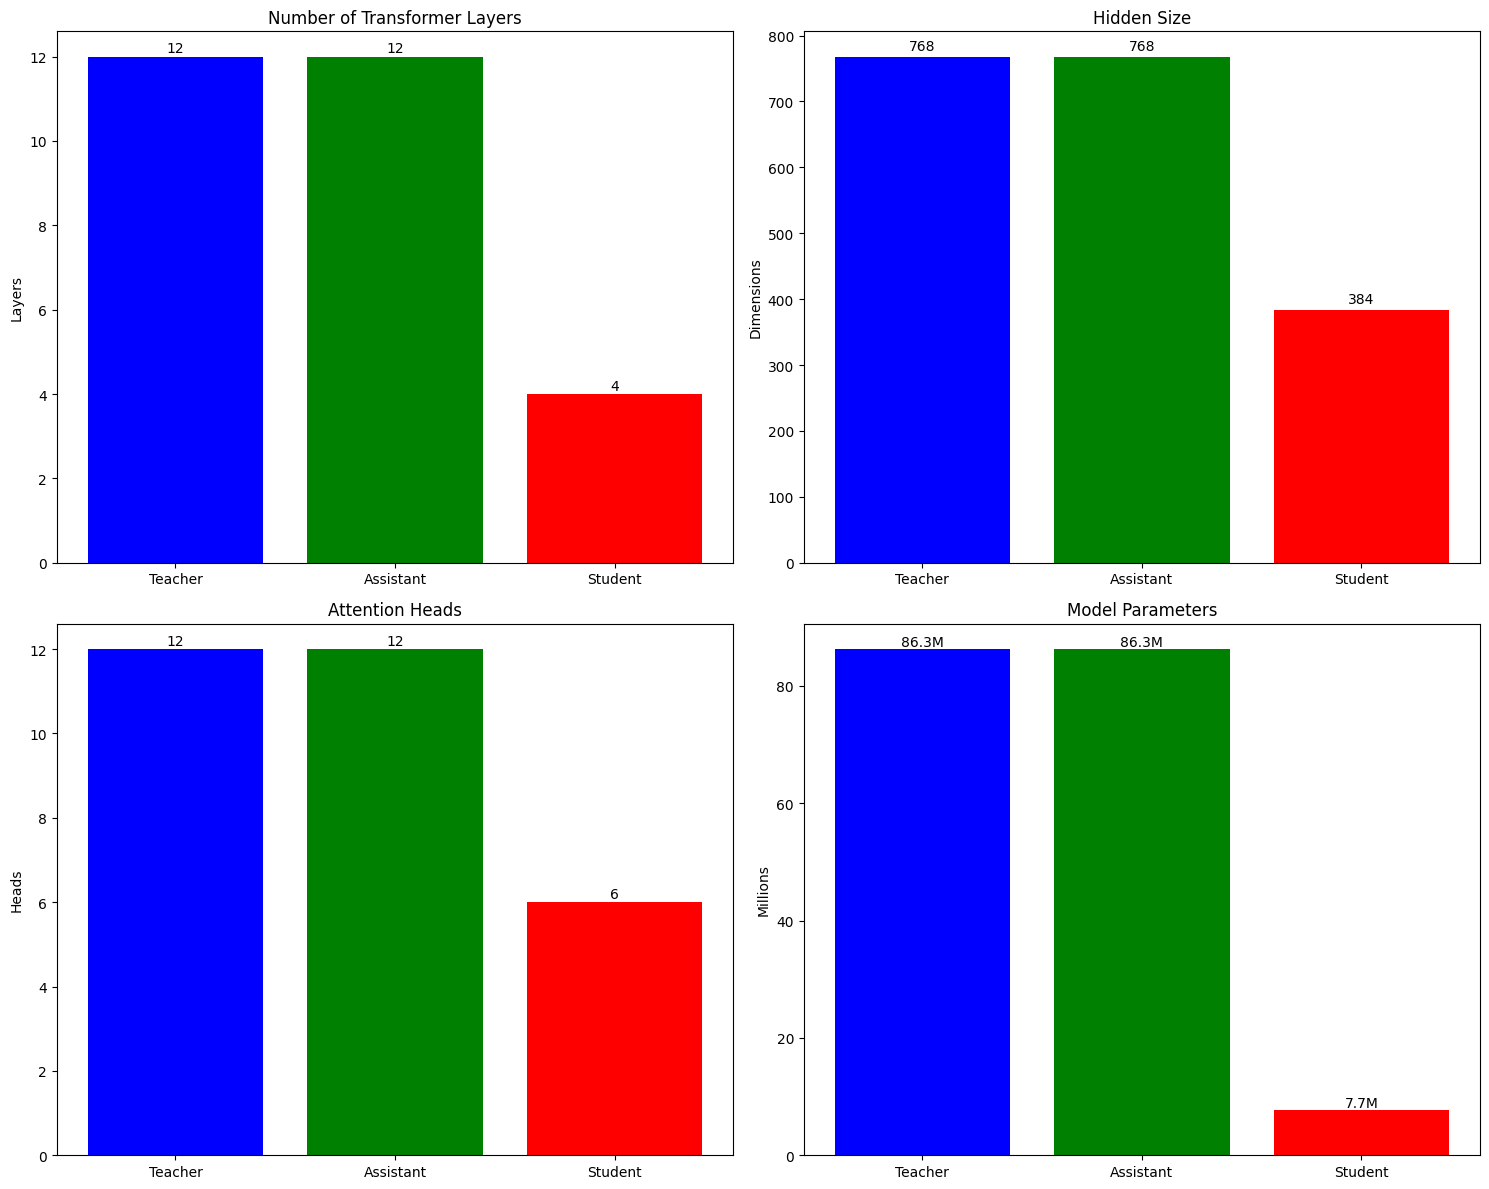


Model architecture comparison:
Teacher: 12 layers, 768 hidden size, 12 heads, 86.3M params
Assistant: 12 layers, 768 hidden size, 12 heads, 86.3M params
Student: 4 layers, 384 hidden size, 6 heads, 7.7M params

Compression ratio (Teacher → Student): 11.2x
Compression ratio (Assistant → Student): 11.2x

Architecture comparison saved to ./tri_model_distilled_sports_multiclass_20250819_174836/architecture_comparison.json

Model architecture analysis completed!


In [13]:
# Model Architecture Comparison

print("\nComparing model architectures...")

# Get model architectures
teacher_config = framework.teacher_model.config
assistant_config = framework.assistant_model.config
student_config = framework.student_model.config

# Extract key parameters
models = ['Teacher', 'Assistant', 'Student']
hidden_sizes = [teacher_config.hidden_size, assistant_config.hidden_size, student_config.hidden_size]
num_layers = [teacher_config.num_hidden_layers, assistant_config.num_hidden_layers, student_config.num_hidden_layers]
num_heads = [teacher_config.num_attention_heads, assistant_config.num_attention_heads, student_config.num_attention_heads]
params = [
    sum(p.numel() for p in framework.teacher_model.parameters()),
    sum(p.numel() for p in framework.assistant_model.parameters()),
    sum(p.numel() for p in framework.student_model.parameters())
]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Number of layers
axes[0, 0].bar(models, num_layers, color=['blue', 'green', 'red'])
axes[0, 0].set_title('Number of Transformer Layers')
axes[0, 0].set_ylabel('Layers')
for i, v in enumerate(num_layers):
    axes[0, 0].text(i, v + 0.1, str(v), ha='center')

# Plot 2: Hidden size
axes[0, 1].bar(models, hidden_sizes, color=['blue', 'green', 'red'])
axes[0, 1].set_title('Hidden Size')
axes[0, 1].set_ylabel('Dimensions')
for i, v in enumerate(hidden_sizes):
    axes[0, 1].text(i, v + 10, str(v), ha='center')

# Plot 3: Attention heads
axes[1, 0].bar(models, num_heads, color=['blue', 'green', 'red'])
axes[1, 0].set_title('Attention Heads')
axes[1, 0].set_ylabel('Heads')
for i, v in enumerate(num_heads):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center')

# Plot 4: Parameters
param_values = [p / 1_000_000 for p in params]  # Convert to millions
axes[1, 1].bar(models, param_values, color=['blue', 'green', 'red'])
axes[1, 1].set_title('Model Parameters')
axes[1, 1].set_ylabel('Millions')
for i, v in enumerate(param_values):
    axes[1, 1].text(i, v + 0.5, f"{v:.1f}M", ha='center')

plt.tight_layout()
plt.show()

# Calculate compression ratios
teacher_student_param_ratio = params[0] / params[2]
assistant_student_param_ratio = params[1] / params[2]

print("\nModel architecture comparison:")
print(f"Teacher: {num_layers[0]} layers, {hidden_sizes[0]} hidden size, {num_heads[0]} heads, {params[0]/1_000_000:.1f}M params")
print(f"Assistant: {num_layers[1]} layers, {hidden_sizes[1]} hidden size, {num_heads[1]} heads, {params[1]/1_000_000:.1f}M params")
print(f"Student: {num_layers[2]} layers, {hidden_sizes[2]} hidden size, {num_heads[2]} heads, {params[2]/1_000_000:.1f}M params")
print(f"\nCompression ratio (Teacher → Student): {teacher_student_param_ratio:.1f}x")
print(f"Compression ratio (Assistant → Student): {assistant_student_param_ratio:.1f}x")

# Save architecture comparison
with open(f"{OUTPUT_DIR}/architecture_comparison.json", "w") as f:
    json.dump({
        "teacher": {
            "layers": int(num_layers[0]),
            "hidden_size": int(hidden_sizes[0]),
            "attention_heads": int(num_heads[0]),
            "parameters": int(params[0])
        },
        "assistant": {
            "layers": int(num_layers[1]),
            "hidden_size": int(hidden_sizes[1]),
            "attention_heads": int(num_heads[1]),
            "parameters": int(params[1])
        },
        "student": {
            "layers": int(num_layers[2]),
            "hidden_size": int(hidden_sizes[2]),
            "attention_heads": int(num_heads[2]),
            "parameters": int(params[2])
        },
        "compression_ratios": {
            "teacher_student": float(teacher_student_param_ratio),
            "assistant_student": float(assistant_student_param_ratio)
        }
    }, f, indent=2)

print(f"\nArchitecture comparison saved to {OUTPUT_DIR}/architecture_comparison.json")
print("\nModel architecture analysis completed!")


In [6]:
import os
from transformers import pipeline
import torch  # For checking device
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Starting evaluation on the full test set...")

# Define paths (relative to the notebook location)
dataset_root_path = "processed_dataset"
test_csv_filename = "test.csv"
test_csv_path = os.path.join(dataset_root_path, test_csv_filename)

local_model_directory = OUTPUT_DIR
absolute_model_path = os.path.abspath(local_model_directory)

# Function to load test data (video paths and true labels)
def load_test_data_from_csv(csv_file_path, data_root_path):
    test_samples = []
    if not os.path.exists(csv_file_path):
        print(f"ERROR: Test CSV file not found at {csv_file_path}")
        return test_samples

    with open(csv_file_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 2:
                relative_video_path = parts[0]  # e.g., "videos/video_000000.mp4"
                true_label_str = parts[1]

                full_video_path = os.path.normpath(os.path.join(data_root_path, relative_video_path))
                test_samples.append((full_video_path, true_label_str))
            elif line.strip():
                print(f"Warning: Malformed line in {csv_file_path}: '{line.strip()}'")
    print(f"Loaded {len(test_samples)} samples from {csv_file_path}")
    return test_samples

# Initialize the video classification pipeline
video_cls = None
print(f"Attempting to load model from: {absolute_model_path}")
if not os.path.isdir(absolute_model_path):
    print(f"ERROR: Model directory not found at {absolute_model_path}")
else:
    print(f"Model directory found. Initializing pipeline...")
    try:
        video_cls = pipeline(
            task="video-classification",
            model=absolute_model_path,
            device=0 if torch.cuda.is_available() else -1  # Use GPU if available
        )
        print(f"Pipeline initialized. Using device: {'cuda:0' if torch.cuda.is_available() else 'cpu'}")
    except Exception as e:
        print(f"Error initializing pipeline: {e}")

if video_cls:
    # Load test data
    test_data = load_test_data_from_csv(test_csv_path, dataset_root_path)

    if test_data:
        total_videos_processed = 0
        true_labels = []
        predicted_labels = []
        top1_correct_predictions = 0
        top5_correct_predictions = 0
        inference_times = []

        print(f"\nStarting inference on {len(test_data)} test videos...")
        for i, (video_path, true_label) in enumerate(test_data):
            if not os.path.exists(video_path):
                print(f"Warning: Video file not found at {video_path}. Skipping.")
                continue

            try:
                start_time = time.time()
                raw_results = video_cls(video_path)
                end_time = time.time()
                inference_times.append(end_time - start_time)
                total_videos_processed += 1

                if not raw_results:
                    print(f"Warning: No results returned for video {video_path}. Skipping.")
                    continue

                # Extract top-5 predicted labels
                top5_results = raw_results[:5]
                predicted_labels_top5 = [res['label'].split('-')[0] for res in top5_results]
                predicted_label_top1 = predicted_labels_top5[0] if predicted_labels_top5 else None

                # Accumulate for per-class report
                if predicted_label_top1 is not None:
                    predicted_labels.append(predicted_label_top1)
                    true_labels.append(true_label)

                # Top-k accuracy
                if predicted_label_top1 == true_label:
                    top1_correct_predictions += 1
                if true_label in predicted_labels_top5:
                    top5_correct_predictions += 1

                if (i + 1) % 10 == 0 or (i + 1) == len(test_data):
                    print(f"  Processed {i + 1}/{len(test_data)} videos...")

            except Exception as e:
                print(f"An error occurred during processing of {video_path}: {e}")

        if total_videos_processed > 0:
            # Accuracies
            top1_accuracy = (top1_correct_predictions / total_videos_processed) * 100
            top5_accuracy = (top5_correct_predictions / total_videos_processed) * 100

            # Timing
            avg_inference_time = sum(inference_times) / len(inference_times)
            fps = 1.0 / avg_inference_time if avg_inference_time > 0 else float('inf')

            print("\n--- Evaluation Complete ---")
            print(f"Total videos processed: {total_videos_processed}")
            print(f"Top-1 Correct Predictions: {top1_correct_predictions}")
            print(f"Top-5 Correct Predictions: {top5_correct_predictions}")
            print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
            print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
            print(f"Average inference time per video: {avg_inference_time:.3f} seconds ({fps:.2f} videos/sec)")

            # Multiclass report/confusion matrix (only for successfully accumulated items)
            if len(predicted_labels) == len(true_labels) and len(true_labels) > 0:
                print("\nDetailed Multiclass Classification Report:")
                print(classification_report(true_labels, predicted_labels, labels=list(label2id.keys())))

                print("\nConfusion Matrix:")
                cm = confusion_matrix(true_labels, predicted_labels, labels=list(label2id.keys()))
                print(cm)
        else:
            print("\n--- Evaluation Complete ---")
            print("No videos were processed successfully.")
    else:
        print("No test data loaded. Cannot perform evaluation.")
else:
    print("Video classification pipeline not initialized. Cannot perform evaluation.")

loading configuration file D:\BIRKBECK\REPOS\videomae-base-finetuned-sports-in-the-wild\tri_model_distilled_sports_multiclass_20250819_221210\config.json
Model config VideoMAEConfig {
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "id2label": {
    "0": "archery",
    "1": "baseball",
    "2": "basketball",
    "3": "bmx",
    "4": "bowling",
    "5": "boxing",
    "6": "cheerleading",
    "7": "discusthrow",
    "8": "diving",
    "9": "football",
    "10": "golf",
    "11": "gymnastics",
    "12": "hammerthrow",
    "13": "highjump",
    "14": "hockey",
    "15": "hurdling",
    "16": "javelin",
    "17": "longjump",
    "18": "polevault",
    "19": "rowing",
    "20": "running",
    "21": "shotput",
    "22": "skating

Starting evaluation on the full test set...
Attempting to load model from: D:\BIRKBECK\REPOS\videomae-base-finetuned-sports-in-the-wild\tri_model_distilled_sports_multiclass_20250819_221210
Model directory found. Initializing pipeline...


All model checkpoint weights were used when initializing VideoMAEForVideoClassification.

All the weights of VideoMAEForVideoClassification were initialized from the model checkpoint at D:\BIRKBECK\REPOS\videomae-base-finetuned-sports-in-the-wild\tri_model_distilled_sports_multiclass_20250819_221210.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VideoMAEForVideoClassification for predictions without further training.
loading configuration file D:\BIRKBECK\REPOS\videomae-base-finetuned-sports-in-the-wild\tri_model_distilled_sports_multiclass_20250819_221210\preprocessor_config.json
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Image processor VideoMAEImageProce

Pipeline initialized. Using device: cuda:0
Loaded 422 samples from processed_dataset\test.csv

Starting inference on 422 test videos...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processed 10/422 videos...
  Processed 20/422 videos...
  Processed 30/422 videos...
  Processed 40/422 videos...
  Processed 50/422 videos...
  Processed 60/422 videos...
  Processed 70/422 videos...
  Processed 80/422 videos...
  Processed 90/422 videos...
  Processed 100/422 videos...
  Processed 110/422 videos...
  Processed 120/422 videos...
  Processed 130/422 videos...
  Processed 140/422 videos...
  Processed 150/422 videos...
  Processed 160/422 videos...
  Processed 170/422 videos...
  Processed 180/422 videos...
  Processed 190/422 videos...
  Processed 200/422 videos...
  Processed 210/422 videos...
  Processed 220/422 videos...
  Processed 230/422 videos...
  Processed 240/422 videos...
  Processed 250/422 videos...
  Processed 260/422 videos...
  Processed 270/422 videos...
  Processed 280/422 videos...
  Processed 290/422 videos...
  Processed 300/422 videos...
  Processed 310/422 videos...
  Processed 320/422 videos...
  Processed 330/422 videos...
  Processed 340/422